### Edgar Moises Hernandez-Gonzalez
#### 11/04/20-24/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### Resize proporcional de 352x125
##### Data Augmentation
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = 64.24%
##### Kappa = 0.5231

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA09E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (125, 352) #ancho, alto
  datos = np.zeros((288,352,125))
  temporal = np.zeros((2816,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      temporal[j*128:(j+1)*128, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

0
100
200


In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

0
100
200


In [0]:
print(x_train.shape)
print(x_test.shape)

(288, 352, 125)
(288, 352, 125)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

145.2552420779481
158.27665508009505
0.001533027630540136
0.0016771057207044145
7.026004893107833
7.155727245399036


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 146.0
x_test /= 146.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.994899
1.0840867
1.0500189e-05
1.1487025e-05
0.048123304
0.049011804


In [0]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 352, 125, 1)
(288, 352, 125, 1)


In [0]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [0]:
# usa el .hdf5
# mc = ModelCheckpoint('best.h5', monitor='val_accuracy', save_best_only=True)
mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CWTDA09.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(8, (3,3), activation='relu', input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1

Epoch 00001: val_accuracy improved from -inf to 0.31250, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CWTDA09.hdf5

Epoch 00002: val_accuracy did not improve from 0.31250

Epoch 00003: val_accuracy did not improve from 0.31250

Epoch 00004: val_accuracy did not improve from 0.31250

Epoch 00005: val_accuracy did not improve from 0.31250

Epoch 00006: val_accuracy did not improve from 0.31250

Epoch 00007: val_accuracy did not improve from 0.31250

Epoch 00008: val_accuracy did not improve from 0.31250

Epoch 00009: val_accuracy did not improve from 0.31250

Epoch 00010: val_accuracy did not improve from 0.31250

Epoch 00011: val_accuracy did not improve from 0.31250

Epoch 00012: val_accuracy did not improve from 0.31250

Epoch 00013: val_accuracy improved from 0.31250 to 0.31597, saving model to /content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CWTDA09.hdf5

Epoch 00014: val_accuracy improved from 0.31597 to 0.43750, saving model to /content/drive/My D

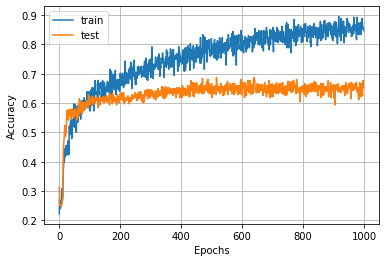

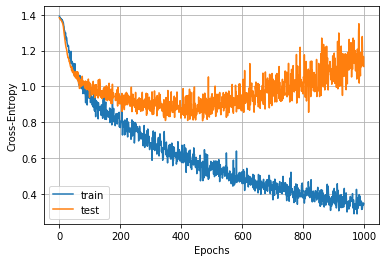

Iteration: 2

Epoch 00001: val_accuracy did not improve from 0.68750

Epoch 00002: val_accuracy did not improve from 0.68750

Epoch 00003: val_accuracy did not improve from 0.68750

Epoch 00004: val_accuracy did not improve from 0.68750

Epoch 00005: val_accuracy did not improve from 0.68750

Epoch 00006: val_accuracy did not improve from 0.68750

Epoch 00007: val_accuracy did not improve from 0.68750

Epoch 00008: val_accuracy did not improve from 0.68750

Epoch 00009: val_accuracy did not improve from 0.68750

Epoch 00010: val_accuracy did not improve from 0.68750

Epoch 00011: val_accuracy did not improve from 0.68750

Epoch 00012: val_accuracy did not improve from 0.68750

Epoch 00013: val_accuracy did not improve from 0.68750

Epoch 00014: val_accuracy did not improve from 0.68750

Epoch 00015: val_accuracy did not improve from 0.68750

Epoch 00016: val_accuracy did not improve from 0.68750

Epoch 00017: val_accuracy did not improve from 0.68750

Epoch 00018: val_accuracy did not 

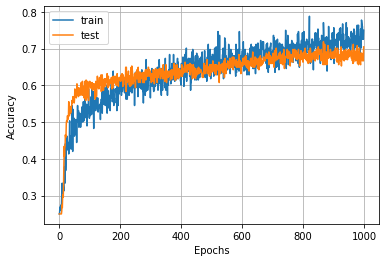

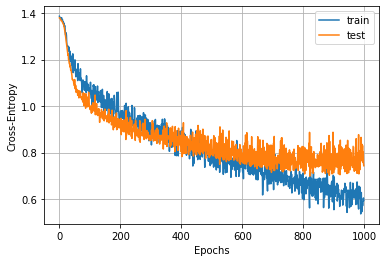

Iteration: 3

Epoch 00001: val_accuracy did not improve from 0.71875

Epoch 00002: val_accuracy did not improve from 0.71875

Epoch 00003: val_accuracy did not improve from 0.71875

Epoch 00004: val_accuracy did not improve from 0.71875

Epoch 00005: val_accuracy did not improve from 0.71875

Epoch 00006: val_accuracy did not improve from 0.71875

Epoch 00007: val_accuracy did not improve from 0.71875

Epoch 00008: val_accuracy did not improve from 0.71875

Epoch 00009: val_accuracy did not improve from 0.71875

Epoch 00010: val_accuracy did not improve from 0.71875

Epoch 00011: val_accuracy did not improve from 0.71875

Epoch 00012: val_accuracy did not improve from 0.71875

Epoch 00013: val_accuracy did not improve from 0.71875

Epoch 00014: val_accuracy did not improve from 0.71875

Epoch 00015: val_accuracy did not improve from 0.71875

Epoch 00016: val_accuracy did not improve from 0.71875

Epoch 00017: val_accuracy did not improve from 0.71875

Epoch 00018: val_accuracy did not 

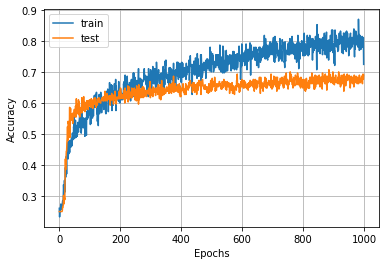

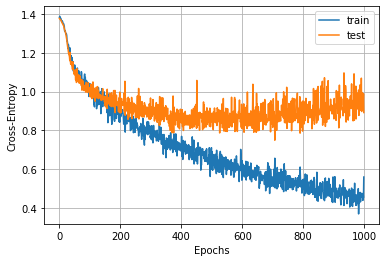

Iteration: 4

Epoch 00001: val_accuracy did not improve from 0.71875

Epoch 00002: val_accuracy did not improve from 0.71875

Epoch 00003: val_accuracy did not improve from 0.71875

Epoch 00004: val_accuracy did not improve from 0.71875

Epoch 00005: val_accuracy did not improve from 0.71875

Epoch 00006: val_accuracy did not improve from 0.71875

Epoch 00007: val_accuracy did not improve from 0.71875

Epoch 00008: val_accuracy did not improve from 0.71875

Epoch 00009: val_accuracy did not improve from 0.71875

Epoch 00010: val_accuracy did not improve from 0.71875

Epoch 00011: val_accuracy did not improve from 0.71875

Epoch 00012: val_accuracy did not improve from 0.71875

Epoch 00013: val_accuracy did not improve from 0.71875

Epoch 00014: val_accuracy did not improve from 0.71875

Epoch 00015: val_accuracy did not improve from 0.71875

Epoch 00016: val_accuracy did not improve from 0.71875

Epoch 00017: val_accuracy did not improve from 0.71875

Epoch 00018: val_accuracy did not 

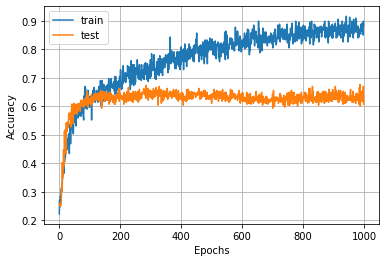

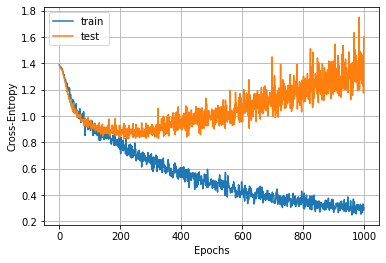

Iteration: 5

Epoch 00001: val_accuracy did not improve from 0.71875

Epoch 00002: val_accuracy did not improve from 0.71875

Epoch 00003: val_accuracy did not improve from 0.71875

Epoch 00004: val_accuracy did not improve from 0.71875

Epoch 00005: val_accuracy did not improve from 0.71875

Epoch 00006: val_accuracy did not improve from 0.71875

Epoch 00007: val_accuracy did not improve from 0.71875

Epoch 00008: val_accuracy did not improve from 0.71875

Epoch 00009: val_accuracy did not improve from 0.71875

Epoch 00010: val_accuracy did not improve from 0.71875

Epoch 00011: val_accuracy did not improve from 0.71875

Epoch 00012: val_accuracy did not improve from 0.71875

Epoch 00013: val_accuracy did not improve from 0.71875

Epoch 00014: val_accuracy did not improve from 0.71875

Epoch 00015: val_accuracy did not improve from 0.71875

Epoch 00016: val_accuracy did not improve from 0.71875

Epoch 00017: val_accuracy did not improve from 0.71875

Epoch 00018: val_accuracy did not 

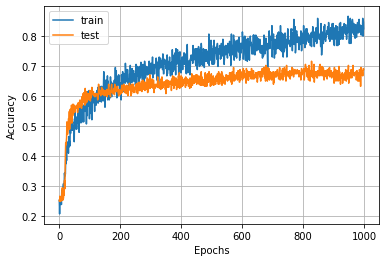

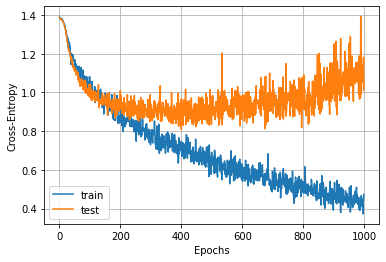


Resultados:
loss: [1.111642426914639, 0.7436274488766988, 0.8918463190396627, 1.599768426683214, 1.0126916699939303]
accuracy: [0.6527777910232544, 0.7048611044883728, 0.6909722089767456, 0.6076388955116272, 0.6875]
kappa: [0.537037037037037, 0.6064814814814814, 0.587962962962963, 0.47685185185185186, 0.5833333333333333]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 350, 123, 8)       80        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 175, 61, 8)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 173, 59, 8)        584       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 86, 29, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 84, 27, 8)         584       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 42, 13, 8)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4368)             

In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6687
std: (+/- 0.0350)
Mean Kappa: 0.5583
std: (+/- 0.0467)
Max Accuracy: 0.7049
Max Kappa: 0.6065
